In [14]:
import torch      #pytorch
import torch.nn as nn     #pytorch network
from torch.utils.data import Dataset, DataLoader      #pytorch dataset
from tensorboardX import SummaryWriter     #tensorboard
import torchvision      #torchvision
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.optim as optim     #pytorch optimizer
import numpy as np      #numpy
import matplotlib.pyplot as plt     #matplotlib(이미지 표시를 위해 필요)
from collections import OrderedDict     #python라이브러리 (라벨 dictionary를 만들 때 필요)
import os     #os
import xml.etree.ElementTree as Et      #Pascal xml을 읽어올 때 필요
from xml.etree.ElementTree import Element, ElementTree
import cv2      #opencv (box 그리기를 할 때 필요)
from PIL import Image     #PILLOW (이미지 읽기)
import time     #time
import imgaug as ia     #imgaug
from imgaug import augmenters as iaa
from torchvision import transforms      #torchvision transform

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [3]:
dataset_path = os.path.expanduser("~/Desktop/joo/data/nest/preprocessing_test/")
classes = ["nest"]

In [4]:
def xml_parser(xml_path):
  xml_path = xml_path

  xml = open(xml_path, "r")
  tree = Et.parse(xml)
  root = tree.getroot()

  size = root.find("size")

  file_name = root.find("filename").text

  object_name = []
  bbox = []

  objects = root.findall("object")
  for _object in objects:
      name = _object.find("name").text
      object_name.append(name)
      bndbox = _object.find("bndbox")
      one_bbox = []
      xmin = bndbox.find("xmin").text
      one_bbox.append(int(float(xmin)))
      ymin = bndbox.find("ymin").text
      one_bbox.append(int(float(ymin)))


      xmax = bndbox.find("xmax").text
      one_bbox.append(int(float(xmax)))
      ymax = bndbox.find("ymax").text
      one_bbox.append(int(float(ymax)))
      

      bbox.append(one_bbox)
  
  return file_name, object_name, bbox

In [5]:
def makeBox(voc_im,bbox,objects):
  image = voc_im.copy()
  for i in range(len(objects)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
    cv2.putText(image, objects[i], (int(bbox[i][0]), int(bbox[i][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2) # 크기, 색, 굵기
  return image

In [6]:
xml_list = os.listdir(dataset_path+"Annotations")
xml_list.sort()

label_set = set()

for i in range(len(xml_list)):
  xml_path = dataset_path+"Annotations/"+str(xml_list[i])
  file_name, object_name, bbox = xml_parser(xml_path)
  for name in object_name:
    label_set.add(name)

label_set = sorted(list(label_set))

label_dic = {}
for i, key in enumerate(label_set):
  label_dic[key] = (i+1)
print(label_dic)


{'nest': 1}


In [7]:
class MydataSet(Dataset):
    
  def __init__(self,xml_list,len_data):

    self.xml_list = xml_list
    self.len_data = len_data
    self.to_tensor = transforms.ToTensor()
    self.flip = iaa.Fliplr(0.5)
    self.resize = iaa.Resize({"shorter-side": 800, "longer-side": "keep-aspect-ratio"})

  def __len__(self):
    return self.len_data

  def __getitem__(self, idx):
    print(f"idx : {idx}")
    print(f"xml_list : {len(xml_list)}")
    xml_path = dataset_path+"Annotations/"+str(xml_list[idx])

    file_name, object_name, bbox = xml_parser(xml_path)
    image_path = dataset_path+"JPEGImages/"+str(file_name)
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    image, bbox = self.flip(image = image, bounding_boxes = np.array([bbox]))
    image, bbox = self.resize(image = image,bounding_boxes = bbox)
    bbox = bbox.squeeze(0).tolist()
    image = self.to_tensor(image)

    targets = []
    d = {}
    d['boxes'] = torch.tensor(bbox,device=device)
    d['labels'] = torch.tensor([label_dic[x] for x in object_name],dtype=torch.int64,device = device)
    targets.append(d)

    return image, targets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx : 30
xml_list : 6703
[{'boxes': tensor([[[369, 358, 434, 445]]], device='cuda:0'), 'labels': tensor([[1]], device='cuda:0')}]


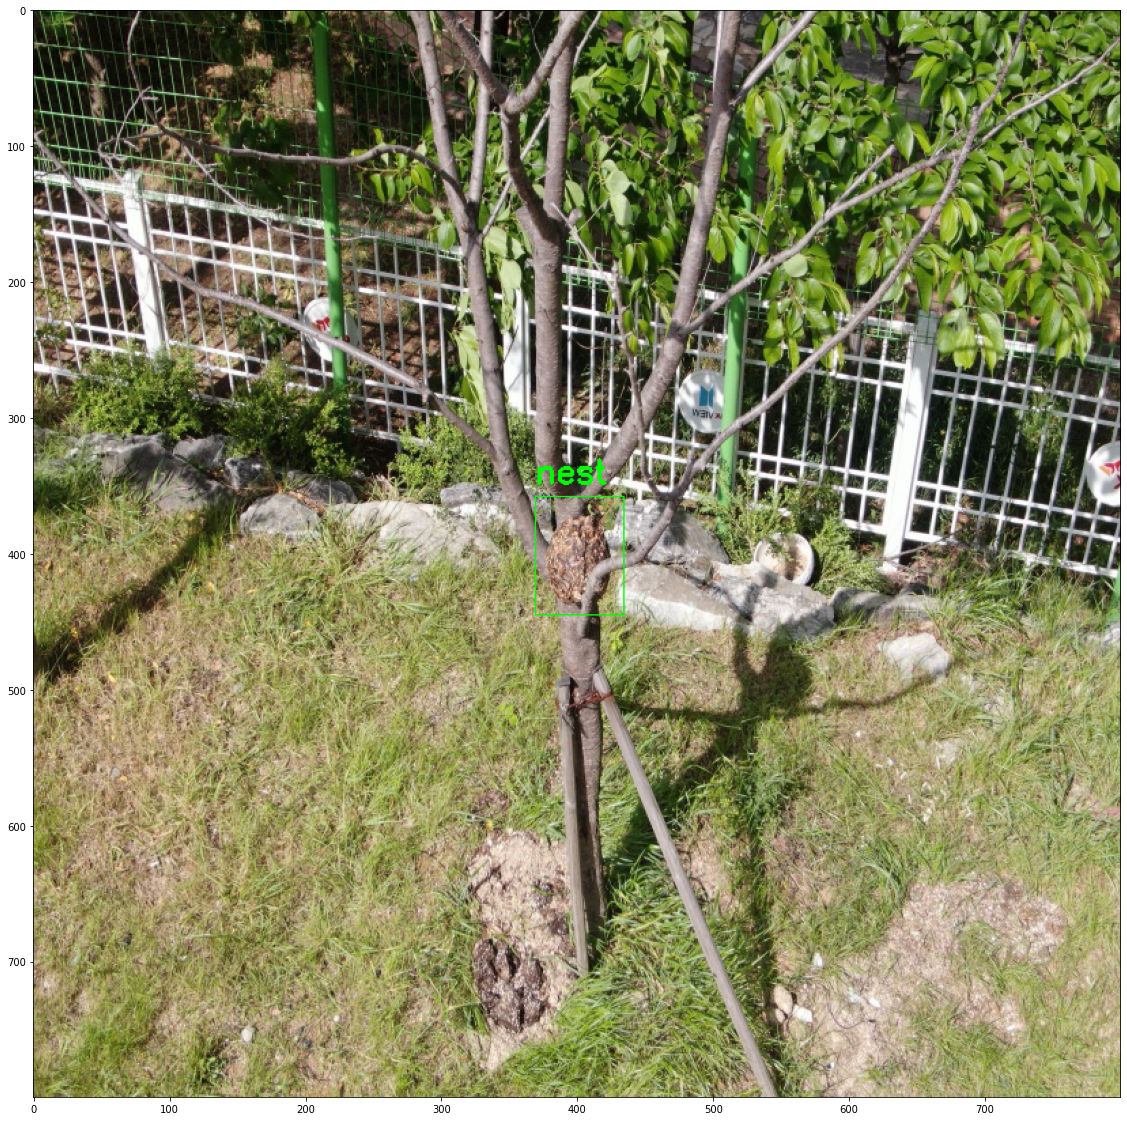

In [16]:
#데이터 테스트 출력
dataset = MydataSet(xml_list, 100)
dataloader = DataLoader(dataset, shuffle=True)

for i, (image, targets) in enumerate(dataloader):
  test_image = image
  test_target = targets
  if i == 0:
    break

print(test_target)

labels = test_target[0]['labels'].squeeze_(0)
objects = []
for lb in labels:
  objects.append([k for k, v in label_dic.items() if v == lb][0])

plot_image = makeBox(test_image.squeeze(0).permute(1, 2, 0).numpy(), test_target[0]['boxes'].squeeze(0), objects)

plt.figure(figsize=(25,20))
plt.imshow(plot_image)

In [17]:
# only print feature extraction part of VGG16

model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)
print(len(features))
print(features)

31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [18]:
# only collect layers with output feature map size (W, H) < 50

dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(device)

for feature in features:
    output = feature(output)
#     print(output.size()) => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16: # 800/16=50
        break
    req_features.append(feature)
    out_channels = output.size()[1]
    
print(len(req_features))
# print(req_features)
print(out_channels)

torch.Size([1, 3, 800, 800])
30
512


In [19]:
# convert this list into a Seqeuntial module
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [20]:
# test the results of the input image pass through the feature extractor

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(test_image).to(device)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.